#Számítógép szemantika projektfeladat

A választott feladat a **SimVerb3500** probléma, amely 3500 igéből álló adatbázis, ahol a szópárok közötti szemantikus kapcsolat egy 1-10-es skálán van értékelve (1 - nem hasonlítanak, 10 - nagyon hasonlítanak). Ugyanakkor ezeknek a szavaknak a relatív kapcsolatuk is dokumentálva van (szinonima, antonima, stb.) amelyet számításaink során fel fogunk használni.

##Kétféle modellt fogunk tesztelni az adathalmazon:
Statikus:
<br>
- **Glove-twitter-100** (2 Mrd tweet, 387MB, 27 Mrd token, 1.2M szótár, uncased (kisbetűs))
<br>
- **Glove-wiki-gigaword-300** (Wikipedia + Gigaword 5, 376MB, 6 Mrd token, uncased)
<br>
- **Word2Vec-google-news-300** (Google Hírek, 1662MB, kb. 100 Mrd szó)

Kontextus alapú:
<br>
- **Bert-base-uncased** (2018, 440M):
<br>
A BERT egy transzformátor-alapú neurális hálózati architektúra, amelyet a Google kutatói 2018-ban mutattak be.
<br>
- **Distilbert-base-uncased** (2019, 245MB):
<br>
A DistilBERT a BERT kisebb és gyorsabb változata, amelyet 2019-ben vezettek be. Kisebb méretét és gyorsabb képzési sebességét a tudásdesztillációnak (knowledge distillation) nevezett technika alkalmazásával éri el. Kisebb mérete ellenére a DistilBERT számos NLP-feladatban a BERT-hez hasonló teljesítményt ér el, így népszerű választás olyan alkalmazásokban, ahol fontos a sebesség és a hatékonyság.
- **Microsoft/Deberta-base** (2020, 390MB):
<br>
A DeBERTa (a "Decoding-enhanced BERT with disentangled attention" rövidítése) a BERT modell egy másik változata. A DeBERTa az eredeti BERT-architektúrát több új funkció beépítésével javítja, többek között a szétválasztott figyelem (disentangled attention), amely lehetővé teszi, hogy a modell jobban kezelje a hosszú szöveges szekvenciákat, valamint a dinamikus maszkolás (dynamic masking), amely segít megakadályozni, hogy a modell túlságosan alkalmazkodjon a képzési adatokhoz.

##A következő kérdésekre fogunk választ keresni:
1. Melyik paraméter számít a statikus modelleinken a legjobban: a tanult korpusz nagysága, a korpusz fajtája, vagy a tokenek mennyisége?
2. Kontextus nélkül a 2 fajta modelleink közül melyik teljesít a legjobban?
3. Kontextussal együtt melyik modellünk a legeffektívebb?
4. Számít-e, ha az igék relációját is figyelembe vesszük?

In [ ]:
#@title Importok
%%capture
!pip3 install -q transformers
!wget https://aclanthology.org/attachments/D16-1235.Attachment.zip
!unzip D16-1235.Attachment.zip
import gensim.downloader as api
import numpy as np
import torch
from sklearn.metrics import mean_squared_error
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
from matplotlib import pyplot as plt

##Statikus reprezentációk elemzése

In [ ]:
#@title "House"-hoz hasonló szavak
vector_model_names = ["glove-twitter-100","glove-wiki-gigaword-300","word2vec-google-news-300"]

for name in vector_model_names:
    model = api.load(name)  # download the model and return as object ready for use
    print("===================================================")
    print(f"Most similar words to 'house' according to {name}:")
    for word, score in model.most_similar("house"):
        print(f"{word}: {score}")
    model.save(name)

Most similar words to 'house' according to glove-twitter-100:
room: 0.8465880155563354
home: 0.8294691443443298
party: 0.7633089423179626
going: 0.7493973970413208
out: 0.7491909861564636
office: 0.7474234104156494
now: 0.7471632957458496
apartment: 0.7466973066329956
up: 0.7463924288749695
family: 0.743867039680481
Most similar words to 'house' according to glove-wiki-gigaword-300:
houses: 0.6481131315231323
senate: 0.6064643859863281
congressional: 0.5572052001953125
congress: 0.5454323291778564
republicans: 0.5355116724967957
building: 0.5348424911499023
white: 0.5315744876861572
mansion: 0.5243033170700073
capitol: 0.5176261067390442
office: 0.516856849193573
Most similar words to 'house' according to word2vec-google-news-300:
houses: 0.7072390913963318
bungalow: 0.6878558993339539
apartment: 0.6628996729850769
bedroom: 0.6496937274932861
townhouse: 0.6384080052375793
residence: 0.6198420524597168
mansion: 0.6058192253112793
farmhouse: 0.5857570171356201
duplex: 0.5757936835289001


In [ ]:
#@title Test dataset
dataset_test = []
for i,l in enumerate(open('data/SimVerb-3000-test.txt')):
  if i==0: continue
  # one line doesn't have a relation type
  if len(l.split()) < 5:
        l += '\tNONE'
  word1, word2, verb, avg_score, relation_type, *_ = l.split()
  #the word misspend doesn't exist as a vector and the ensure line is bad
  if word1 != 'misspend':
    dataset_test.append((word1, word2, float(avg_score), relation_type))

np.random.seed(42)
np.random.shuffle(dataset_test)

print("===Példa inputok===")
for x in dataset_test[0:3]:
  print(x)
print(len(dataset_test))
avg_similarity = np.mean([data[2] for data in dataset_test])
print(f"Átlagos hasonlóság: {avg_similarity:.2f}")

===Példa inputok===
('steal', 'abduct', 5.64, 'NONE')
('inform', 'ask', 2.49, 'COHYPONYMS')
('brush', 'paint', 6.97, 'COHYPONYMS')
2999
Átlagos hasonlóság: 4.29


In [ ]:
#@title Eval dataset

dataset_eval = []
for i,l in enumerate(open('data/SimVerb-500-dev.txt')):
  if i==0: continue
  # one line doesn't have a relation type
  if len(l.split()) < 5:
        l += '\tNONE'
  word1, word2, verb, avg_score, relation_type, *_ = l.split()
  #the word misspend doesn't exist as a vector and the ensure line is bad
  if word1 != 'misspend':
    dataset_eval.append((word1, word2, float(avg_score), relation_type))

np.random.seed(42)
np.random.shuffle(dataset_eval)

print(len(dataset_eval))
avg_similarity = np.mean([data[2] for data in dataset_eval])
print(f"Átlagos hasonlóság: {avg_similarity:.2f}")

498
Átlagos hasonlóság: 4.32


In [ ]:
#@title Modellek összehasonlítása
from sklearn.metrics import mean_squared_error
diff = {}
avg_loss = {}
outputs_dict = {}
print("Model neve/Veszteség(minél kevesebb annál jobb az eredmény)")
for model_name in vector_model_names:
  model = api.load(model_name)
  diff[model_name] = []
  avg_loss[model_name] = []
  outputs_dict[model_name] = []
  for (w1, w2, avg_score, relation_type) in dataset_eval:

    outputs = model.similarity(w1, w2) * 10
    
    outputs_dict[model_name].append(outputs)

    diff[model_name].append(avg_score)

  avg_loss[model_name] = mean_squared_error(outputs_dict[model_name], diff[model_name])
  print(f"{model_name}/{avg_loss[model_name]:.3f}")

Model neve/Veszteség(minél kevesebb annál jobb az eredmény)
glove-twitter-100/9.436
glove-wiki-gigaword-300/8.995
word2vec-google-news-300/7.531


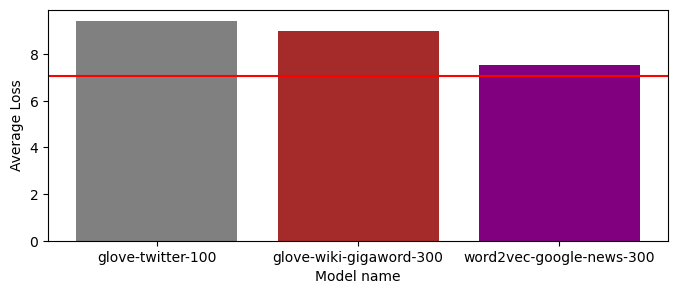

In [ ]:
#@title Plot ábrázolása
#baseline
diff_bl = []
for (w1, w2, avg_score, relation_type) in dataset_eval:

    outputs = (4.32) # predikciók értéke
    
    differences = avg_score - outputs
    
    mean_squared_error = np.mean(differences**2)

    diff_bl.append(mean_squared_error)

bl = np.mean(diff_bl)


fig, ax = plt.subplots(figsize=(8,3))
colors = ['gray', 'brown', 'purple']
ax.bar(vector_model_names, avg_loss.values(), color=colors)
plt.axhline(y=bl, color='red', linestyle='-')
ax.set_ylabel('Average Loss')
ax.set_xlabel('Model name')
plt.show()

Nem túl bíztató eredményeket kaptunk, nézzük meg ezeket személyesen

In [ ]:
model = api.load("glove-twitter-100")

In [ ]:
print(np.mean([data[2] for data in dataset_eval]))
print(np.mean(outputs_dict["glove-twitter-100"]))
print(np.std([data[2] for data in dataset_eval]))
print(np.std(outputs_dict["glove-twitter-100"]))
# az adathalmazon jóval nagyobb a szórás, más módon kellene a két számot összehasonlítani
print("-----------")
print(min(outputs_dict["glove-twitter-100"])) #létezik negatív kapcsolat is, amit javítani kellene
print(max(outputs_dict["glove-twitter-100"]))
print("-----------")
print(dataset_eval[0])
print(outputs_dict['glove-twitter-100'][0])
print(model.similarity('release', 'give')*10)

sc = dataset_eval[0][2] - outputs_dict['glove-twitter-100'][0]
print(sc**2)
print((3.32-5.729770064353943)**2)
#az MSE kiszámítása jó
print("-----------")
release = model.get_vector("release")
give = model.get_vector("give")
similarity = (release.dot(give)) / (np.linalg.norm(release) * np.linalg.norm(give))
print(similarity*10)
#a similarity function is jól működik

4.315200803212851
4.325711117817994
2.656770478861272
1.8535364854725687
-----------
-0.7052219659090042
8.83349597454071
-----------
('release', 'give', 3.32, 'COHYPONYMS')
5.729770064353943
5.729770064353943
5.8069917630564065
5.8069917630564065
-----------
5.729770064353943


In [ ]:
#@title Modellek összehasonlítása 2.
from sklearn.metrics import mean_squared_error
diff = {}
avg_loss_2 = {}
outputs_dict_2 = {}
min_sim = {}
max_sim = {}
sim_range = {}
scaled_sim = {}
print("Model neve/Veszteség(minél kevesebb annál jobb az eredmény)")
for model_name in vector_model_names:
  model = api.load(model_name)
  diff[model_name] = []
  avg_loss_2[model_name] = []
  outputs_dict_2[model_name] = []
  min_sim[model_name] = []
  max_sim[model_name] = []
  sim_range[model_name] = []
  scaled_sim[model_name] = []
  for (w1, w2, avg_score, relation_type) in dataset_eval:

    outputs = model.similarity(w1, w2)

    outputs_dict_2[model_name].append(outputs)

    diff[model_name].append(avg_score)

  # megpróbáljuk normalizálni 0-10-ig az értékeket
  min_sim[model_name] = min(outputs_dict_2[model_name])
  max_sim[model_name] = max(outputs_dict_2[model_name])
  sim_range[model_name] = max_sim[model_name] - min_sim[model_name]
  scaled_sim[model_name] = ((outputs_dict_2[model_name] - min_sim[model_name]) / sim_range[model_name]) * 10

  avg_loss_2[model_name] = mean_squared_error(scaled_sim[model_name], diff[model_name])
  print(f"{model_name}/{avg_loss_2[model_name]:.3f}")

Model neve/Veszteség(minél kevesebb annál jobb az eredmény)
glove-twitter-100/10.645
glove-wiki-gigaword-300/7.971
word2vec-google-news-300/6.480


Érdekes eredmény jött ki! A twitteres rosszabb lett, a másik kettő pedig jobb eredményt adott.
<br>

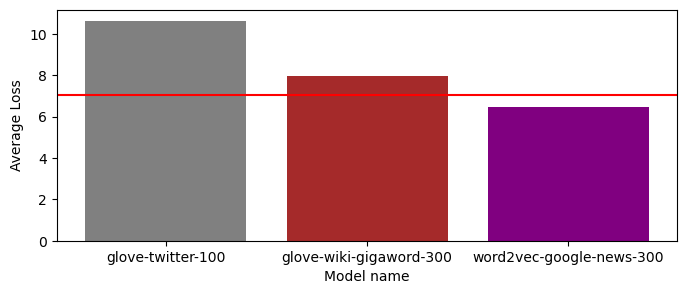

In [ ]:
#@title Plot ábrázolása
fig, ax = plt.subplots(figsize=(8,3))
colors = ['gray', 'brown', 'purple']
ax.bar(vector_model_names, avg_loss_2.values(), color=colors)
plt.axhline(y=bl, color='red', linestyle='-')
ax.set_ylabel('Average Loss')
ax.set_xlabel('Model name')
plt.show()

Nézzük meg újra a statisztikai adatainkat

In [ ]:
model = api.load("word2vec-google-news-300")

In [ ]:
print("Átlagok")
print(np.mean([data[2] for data in dataset_eval]))
print(np.mean(outputs_dict["word2vec-google-news-300"]))
print(np.mean(scaled_sim["word2vec-google-news-300"]))
print("Szórás")
print(np.std([data[2] for data in dataset_eval]))
print(np.std(outputs_dict["word2vec-google-news-300"]))
print(np.std(scaled_sim["word2vec-google-news-300"]))
print("Hibaérték")
print(avg_loss['word2vec-google-news-300'])
print(avg_loss_2['word2vec-google-news-300'])

Átlagok
4.315200803212851
3.0679744501489714
4.176476
Szórás
2.656770478861272
1.4967883935286785
1.9065431
Hibaérték
7.531382997038246
6.479895407824483


Az eredményünk javult

In [ ]:
#@title Spearman és pearson korreláció elemzése
from scipy.stats import spearmanr
from scipy.stats import pearsonr

s_results = {}
p_results = {}

print("Spearman:")

for name in vector_model_names:
  s_results[name] = spearmanr(scaled_sim[name], diff[name])
  
  print(f"{name} : \nR érték: {s_results[name].statistic:.3f}, p érték: {s_results[name].pvalue:.3f}\n")

print("================")
print("Pearson:")

for name in vector_model_names:
  p_results[name] = pearsonr(scaled_sim[name], diff[name])
  
  print(f"{name} : \nR érték: {p_results[name].statistic:.3f}, p érték: {p_results[name].pvalue:.3f}\n")

Spearman:
glove-twitter-100 : 
R érték: 0.109, p érték: 0.015

glove-wiki-gigaword-300 : 
R érték: 0.267, p érték: 0.000

word2vec-google-news-300 : 
R érték: 0.391, p érték: 0.000

Pearson:
glove-twitter-100 : 
R érték: 0.107, p érték: 0.016

glove-wiki-gigaword-300 : 
R érték: 0.277, p érték: 0.000

word2vec-google-news-300 : 
R érték: 0.418, p érték: 0.000



Itt is meglátható az erősségi sorrend, de a p érték viszont nagyon kevés

---
##Kontextuális reprezentációk elemzése
---

In [ ]:
#@title Segédfüggvény a kontextus létrehozásához
def convert_input(list_of_inputs, w1, w2, relation_type, approach):
  """
  Append the list_of_inputs with the word pair (w1, w2) determined by the approach parameter.
  When approach==0, simple concatenation happens, i.e. it becomes [CLS] w1 [SEP] w2
  When approach==1, the word pair is included in a natural sounding sentence
  """
  if approach==0:
    list_of_inputs.append([w1, w2])
  elif approach==1:
    list_of_inputs.append(f"To {w1} is like to {w2}.")
  elif approach==2:
    if relation_type != "NONE":
      rt = str.lower(relation_type)
      list_of_inputs.append(f"To {w1} is like to {w2}. They are {rt}.")
    else:
      list_of_inputs.append(f"To {w1} is like to {w2}. They are not related.")
  else:
    raise Exception(f"Input template {approach} unrecognized")

In [ ]:
#@title Paraméterek beállítása
context_based_model_names = ['microsoft/deberta-base', 'distilbert-base-uncased', 'bert-base-uncased']
batch_size = 16
epoch_number = 5
input_templates = [0,1,2]
lr=4e-5

batches_per_epoch = len(dataset_test) // batch_size + 1
print(f"Tanítópéldák/kötegek száma: {len(dataset_test)}/{batches_per_epoch}")

print("\nA vizsgált hiperparaméterkombinációk:")
hyperparameter_combo = [(mn, it) for mn in context_based_model_names for it in input_templates]
for hc in hyperparameter_combo:
  print(f"* {hc}")

Tanítópéldák/kötegek száma: 2999/188

A vizsgált hiperparaméterkombinációk:
* ('microsoft/deberta-base', 0)
* ('microsoft/deberta-base', 1)
* ('microsoft/deberta-base', 2)
* ('distilbert-base-uncased', 0)
* ('distilbert-base-uncased', 1)
* ('distilbert-base-uncased', 2)
* ('bert-base-uncased', 0)
* ('bert-base-uncased', 1)
* ('bert-base-uncased', 2)


In [ ]:
#@title Modellek összehasonlítása
%%capture
loss_values = {}
evaluation_metrics = {}
predictions = {}
for mn, it in hyperparameter_combo:
  current_hyperparameters = (mn, lr, batch_size, epoch_number, it)

  c = AutoConfig.from_pretrained(mn,
                                 output_hidden_states=False,
                                 num_labels=1 # regressziós feladatot oldunk meg
                                 )
  model = AutoModelForSequenceClassification.from_pretrained(mn, config=c)
  model.to('cuda') # ha szeretnénk/tudunk GPU-t használni a tanítás során
  tokenizer = AutoTokenizer.from_pretrained(mn)
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

  loss_values[current_hyperparameters] = []
  evaluation_metrics[current_hyperparameters] = []
  predictions[current_hyperparameters] = []

  for epoch in range(epoch_number):
    model.train() # átbillentjük tanító "állásba" a modellt
    np.random.shuffle(dataset_test)

    for batch_id in range(batches_per_epoch):
      from_idx = batch_id * batch_size
      to_idx = (batch_id+1) * batch_size
      batch_content = dataset_test[from_idx:to_idx]
    
      text_input, y = [], []
      for (word1, word2, score, relation_type) in batch_content:
        convert_input(text_input, word1, word2, relation_type, it)
        y.append(score)
      input = tokenizer(text_input, padding=True, return_tensors='pt').to(model.device)

      outputs = model(**input, labels=torch.tensor(y, device=model.device))
    
      loss_values[current_hyperparameters].append(outputs.loss.item())
      outputs.loss.backward() # hibavisszaterjesztés
      optimizer.step()
      optimizer.zero_grad() # a gradiens akkumulálódását megelőlegezendő
  
    #kiértékelés
    model.eval()
    text_input, y = [], []
    for test_w1, test_w2, test_score, relation_type in dataset_eval:
      convert_input(text_input, test_w1, test_w2, relation_type, it)
      y.append(test_score)

    input = tokenizer(text_input, padding=True, return_tensors='pt').to(model.device)

    with torch.no_grad():
      outputs = model(**input).logits.squeeze() # predikciók vektora
      expected_outputs = torch.tensor(y, device=model.device) # elvárt predikciók vektora
      differences = expected_outputs - outputs
      mean_squared_error = torch.mean(differences**2).item()

      evaluation_metrics[current_hyperparameters].append(mean_squared_error)
      predictions[current_hyperparameters].append(outputs.detach().cpu())

    loss_avg = np.mean(loss_values[current_hyperparameters])
    #print(f"Epoch {epoch+1} vége: átlagos tanítóhiba/tesztmetrika {np.mean(loss_avg):.3f}/{mean_squared_error:.3f}")
  model.save_pretrained('_'.join(map(str, current_hyperparameters)))

A ('microsoft/deberta-base', 4e-05, 16, 5, 0) hiperparaméterek mellett az egyes batchek végén kapott metrikák értékei: [7.11 7.08 7.07 7.11 7.24]
A ('microsoft/deberta-base', 4e-05, 16, 5, 1) hiperparaméterek mellett az egyes batchek végén kapott metrikák értékei: [4.35 4.16 3.74 3.4  3.71]
A ('microsoft/deberta-base', 4e-05, 16, 5, 2) hiperparaméterek mellett az egyes batchek végén kapott metrikák értékei: [3.83 2.99 3.22 2.53 2.75]
A ('distilbert-base-uncased', 4e-05, 16, 5, 0) hiperparaméterek mellett az egyes batchek végén kapott metrikák értékei: [7.05 6.75 6.15 6.05 6.02]
A ('distilbert-base-uncased', 4e-05, 16, 5, 1) hiperparaméterek mellett az egyes batchek végén kapott metrikák értékei: [7.05 7.09 6.14 6.16 7.09]
A ('distilbert-base-uncased', 4e-05, 16, 5, 2) hiperparaméterek mellett az egyes batchek végén kapott metrikák értékei: [4.55 4.2  3.98 4.44 5.93]
A ('bert-base-uncased', 4e-05, 16, 5, 0) hiperparaméterek mellett az egyes batchek végén kapott metrikák értékei: [7.12 6

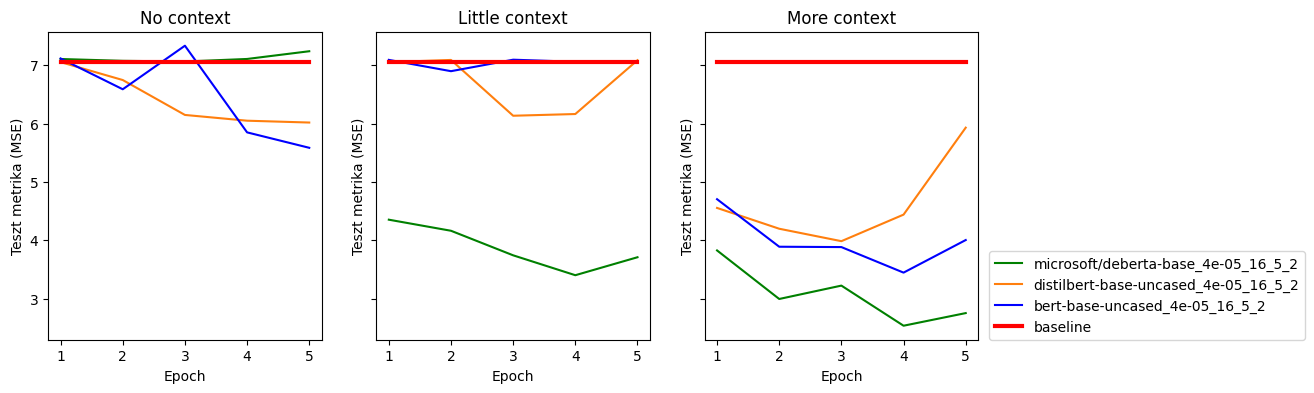

In [ ]:
#@title Adatok kiírása, plotolás
fig, axs = plt.subplots(1,3, sharey=True, figsize=(12,4))

for hyperparams, metric in evaluation_metrics.items():
  rounded_metric = np.round(metric, decimals=2)
  print(f"A {hyperparams} hiperparaméterek mellett az egyes batchek végén kapott metrikák értékei: {rounded_metric}")
  hyperparam_str = '_'.join(map(str, hyperparams))
  if "distilbert" in hyperparams[0]:
    style = '#ff7f0e'
  elif "deberta" in hyperparams[0]:
    style = 'g'
  else:
    style = 'b'
  axs[hyperparams[-1]].plot(range(1, epoch_number+1), metric, style, label=hyperparam_str)

baseline_performance = torch.mean((expected_outputs - avg_similarity)**2).item()

for input_approach, ax in enumerate(axs):
  ax.plot([1,epoch_number], [baseline_performance, baseline_performance], 'r', label='baseline', linewidth=3.)
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Teszt metrika (MSE)")
  ax.set_xticks(range(1, epoch_number+1))
  if input_approach==0:
    ax.set_title("No context")
  elif input_approach==1:
    ax.set_title("Little context")
  else:
    ax.set_title("More context")
plt.legend(loc=(1.04, 0))
plt.show()

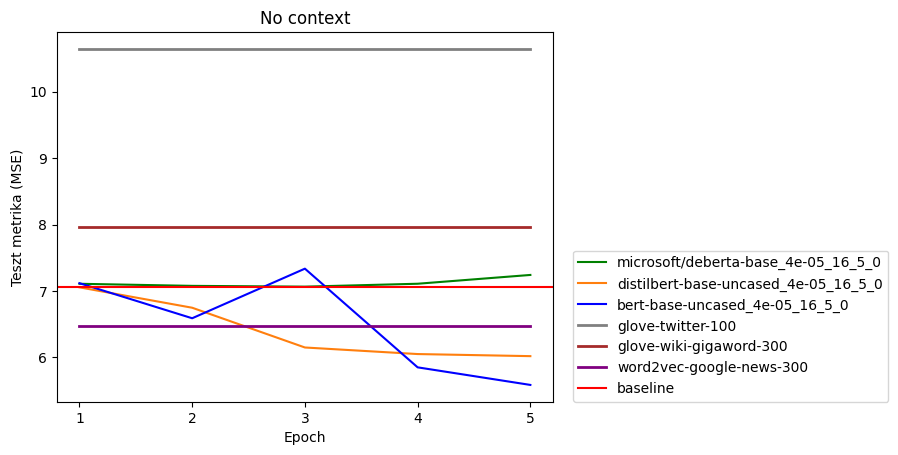

In [ ]:
#@title A kétféle modellek összehasonlítása
fig, ax = plt.subplots()

for hyperparams, metric in evaluation_metrics.items():
  if hyperparams[4] == 0: # only plot for "No context" input approach
    rounded_metric = np.round(metric, decimals=2)
    hyperparam_str = '_'.join(map(str, hyperparams))
    if "distilbert" in hyperparams[0]:
      style = '#ff7f0e'
    elif "deberta" in hyperparams[0]:
      style = 'g'
    else:
      style = 'b'
    ax.plot(range(1, epoch_number+1), metric, style, label=hyperparam_str)

line_glove_twitter_100 = avg_loss_2['glove-twitter-100']
line_glove_wiki_300 = avg_loss_2['glove-wiki-gigaword-300']
word2vec_google_news_300 = avg_loss_2['word2vec-google-news-300']

ax.plot([1,epoch_number], [line_glove_twitter_100, line_glove_twitter_100], 'gray', label='glove-twitter-100', linewidth=2.)
ax.plot([1,epoch_number], [line_glove_wiki_300, line_glove_wiki_300], 'brown', label='glove-wiki-gigaword-300', linewidth=2.)
ax.plot([1,epoch_number], [word2vec_google_news_300, word2vec_google_news_300], 'purple', label='word2vec-google-news-300', linewidth=2.)
plt.axhline(y=bl, color='red', linestyle='-', label='baseline')
ax.set_xlabel("Epoch")
ax.set_ylabel("Teszt metrika (MSE)")
ax.set_xticks(range(1, epoch_number+1))
ax.set_title("No context")
plt.legend(loc=(1.04, 0))
plt.show()


---
Felhasznált linkek:
<br>
[Adatbázis](https://aclanthology.org/D16-1235/)
<br>
[Statikus modellek](https://github.com/RaRe-Technologies/gensim-data)
<br>
[BERT](https://huggingface.co/bert-base-uncased)
<br>
[DeBERTa](https://huggingface.co/microsoft/deberta-base)
<br>
[DistilBERT](https://huggingface.co/distilbert-base-uncased)